## 1. 指标定义
### 1.1 定义
&emsp;&emsp;60日均线偏离率：当日收盘价和60日回归均值的变差比例。

&emsp;&emsp;用于反馈短期内股价和近60天均线的偏差，进而体现短期波动情况。类似有10日均线偏差、120日均线偏差等。

### 1.2 计算逻辑
&emsp;&emsp;60日均线计算公式：

${\mathop{{MA}}\nolimits_{{60\text{ }}}={\mathop{ \sum }\nolimits_{{60}}^{{i=1}}{\mathop{{close}}\nolimits_{{i}}}}\text{ }/\text{ }60}$ ， 其中 close 表示当日收盘价。

&emsp;&emsp;60日均线偏离率计算公式：

${Rate\text{ }=\text{ } \left( close\text{ }/\text{ }MA\mathop{{}}\nolimits_{{60}} \left) \text{ }-\text{ }1\right. \right. }$

## 2. 使用场景

### 2.1 使用场景

&emsp;&emsp;60日均线偏离率公式很简单，主要反映短期内的异常波动和近两个月平均值之间的偏差有多大。

&emsp;&emsp;（1）当市场受到政策、情绪因素影响较大时，会出现急涨急跌的情况，进而使得股价短期内远远偏离价值；

### 2.2 如何使用

&emsp;&emsp;（1）如果偏离率达到近几年内最高时，可以作为短期减持依据，进而避免均值回归；

&emsp;&emsp;（2）并不能用做买入卖出的判断依据，而是在市场极度波动情况下的一种短期操作依据。



In [67]:
import baostock as bs
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

lg = bs.login()

# 获取MA60数据
def get_ma_data(stock, start_date, end_date):
  data_array = []
  res = bs.query_history_k_data_plus(
    stock,
    "date,code,close",
    start_date=start_date,
    end_date=end_date,
    frequency="d",
    adjustflag="3",
  )
  while (res.error_code == '0') & res.next():
    data_array.append(res.get_row_data())
  result = pd.DataFrame(data_array, columns=res.fields)
  result['MA60'] = result['close'].rolling(window=60).mean()
  dropedResult = result.dropna(subset=['close', 'MA60'])
  dropedResult['deviate_rate'] = dropedResult['close'].astype(float) / dropedResult['MA60'].astype(float) - 1
  maxRate = dropedResult['deviate_rate'].astype(float).max()
  minRate = dropedResult['deviate_rate'].astype(float).min()
  latestRate = dropedResult['deviate_rate'].astype(float).iloc[-1]
  latestRateLevel = (latestRate - minRate) / (maxRate - minRate)
  dropedResult['latest_rate_level'] = (dropedResult['deviate_rate'].astype(float) - minRate) / (maxRate - minRate)
  print('dropedResult -->', dropedResult)
  print('max rate is', maxRate * 100, '%')
  print('min rate is', minRate * 100, '%')
  print('latest rate is', latestRate * 100, '%')
  print('latest rate level is', latestRateLevel * 100, '%')
  return dropedResult


login success!


In [68]:
# 绘制
def draw_plot(data):
  data['latest_rate_level'] = data['latest_rate_level'] * 100
  interval = 50
  x_labels = data['date'].astype(str)
  x_labels_sampled = x_labels[::interval]
  # 绘制折线图
  plt.figure(figsize=(20, 8))  # 设置图形的大小
  plt.plot(data['date'], data['deviate_rate'], linestyle='-', color='#db5a6b')  # 绘制折线图
  plt.title('Deviate Rate Over Ten Years')  # 设置图形的标题
  plt.xlabel('Date')  # 设置x轴的标签
  plt.ylabel('Deviate Rate (%)')  # 设置y轴的标签
  plt.grid(True)  # 显示网格
  plt.xticks(data['date'][::interval], x_labels_sampled, rotation=45)
  plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
  plt.show()  # 显示图形

/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenhao/Downloads/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropedResult -->            date       code    close       MA60  deviate_rate  \
59   2022-09-14  sh.603288  81.9000  82.366500     -0.005664   
60   2022-09-15  sh.603288  81.6000  82.352000     -0.009132   
61   2022-09-16  sh.603288  80.9400  82.316167     -0.016718   
62   2022-09-19  sh.603288  81.4700  82.271000     -0.009736   
63   2022-09-20  sh.603288  80.7800  82.162333     -0.016824   
..          ...        ...      ...        ...           ...   
722  2025-06-16  sh.603288  40.1200  42.243833     -0.050276   
723  2025-06-17  sh.603288  40.4300  42.226833     -0.042552   
724  2025-06-18  sh.603288  40.2300  42.206500     -0.046829   
725  2025-06-19  sh.603288  38.6900  42.171500     -0.082556   
726  2025-06-20  sh.603288  38.5100  42.145333     -0.086257   

     latest_rate_level  
59            0.392721  
60            0.388040  
61            0.377799  
62            0.387224  
63            0.377656  
..                 ...  
722           0.332503  
723           

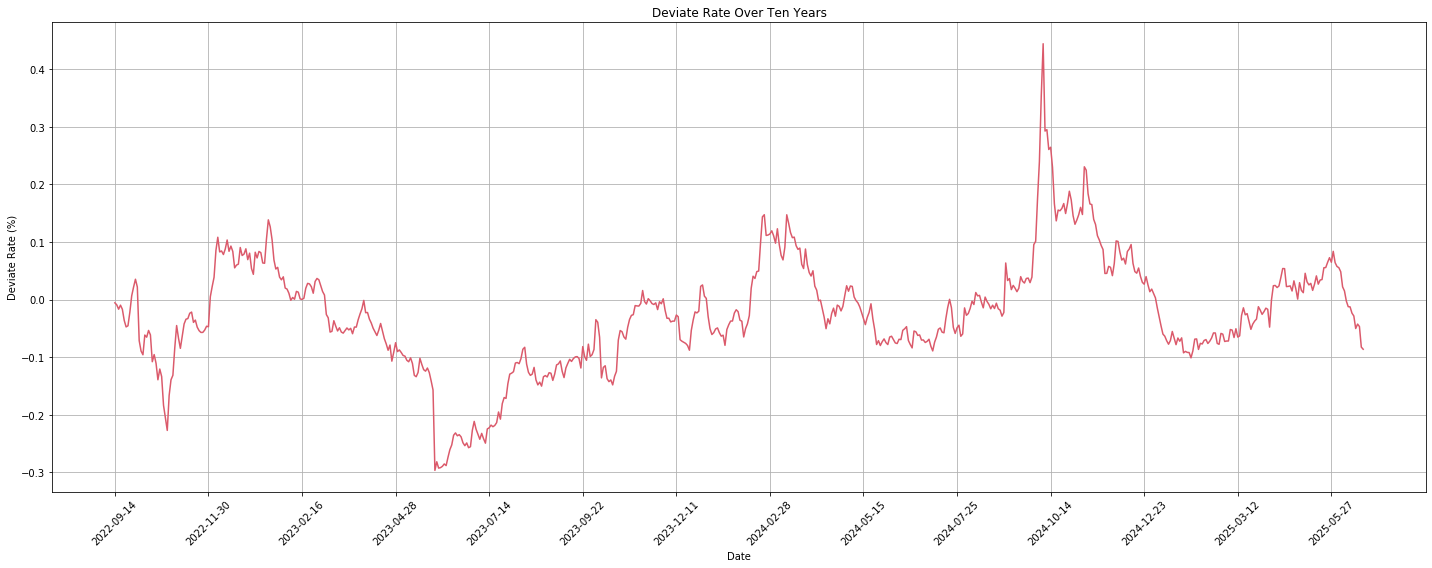

In [69]:
def main(stock, years):
  # 起始日期为当前日期十年前，终止日期为今日
  # 日期格式为YYYY-MM-DD
  days = years * 365
  start_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')
  end_date = datetime.now().strftime('%Y-%m-%d')
  # 获取数据
  data = get_ma_data(stock, start_date, end_date)
  draw_plot(data)

if __name__ == '__main__':
  main('sh.603288', 3)